# Import

In [1]:
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
from IPython import display
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
import inspect
import tensorboard
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
import itertools
import matplotlib.colors as mcolors
import glob, os

In [2]:
import logging
logging.getLogger('lightning').setLevel(0)
pl.utilities.distributed.log.setLevel(logging.ERROR)

In [3]:
import platform
print(platform.platform())

Linux-5.10.133+-x86_64-with-glibc2.35


In [4]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

# Useful functions

In [5]:
line_styles = ['solid', 'dashed', 'dotted', 'dashdot']

For testing

In [6]:
def central_diffs_x(dataArray) :
    return 0.5*(torch.roll(dataArray, shifts=-1, dims=0) - torch.roll(dataArray, shifts=1, dims=0))
def central_diffs_y(dataArray) :
    return 0.5*(torch.roll(dataArray, shifts=-1, dims=1) - torch.roll(dataArray, shifts=1, dims=1))

In [7]:
def central_diffs_x_2(dataArray) :
    return (torch.roll(dataArray, shifts=-1, dims=0) - 2.*dataArray.clone() + torch.roll(dataArray, shifts=1, dims=0))
def central_diffs_y_2(dataArray) :
    return (torch.roll(dataArray, shifts=-1, dims=1) - 2.*dataArray.clone() + torch.roll(dataArray, shifts=1, dims=1))

In [8]:
def finite_diffs_sqr_2d_array(dataArray) :
    return torch.pow(central_diffs_x(dataArray),2) + torch.pow(central_diffs_y(dataArray),2)
    #return (central_diffs_y(dataArray)).clone()
    #return torch.pow(central_diffs_x_2(dataArray),2) + torch.pow(central_diffs_y_2(dataArray),2)

A function that allows to read the logs in tensorboars format and returns them as a python dictionary:

In [9]:
def get_logs_from_tb(exp_name, version_name, directory='logs/') :
    dictionary = dict()
    # for var in list_of_vars :
    #     dictionary[var] = list()
    file_name = glob.glob(directory + '/' + exp_name + '/' + version_name + '/events.out.*')[-1]
    print(file_name)
    for event in EventFileLoader(file_name).Load() :
        if (len(event.summary.value) > 0) :
            if (event.summary.value[0].tag not in dictionary) :
                dictionary[event.summary.value[0].tag] = []
            (dictionary[event.summary.value[0].tag]).append(event.summary.value[0].tensor.float_val)
    return dictionary

# Data properties

In [10]:
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET'] 

In [11]:
time_slice = dict(time_counter=slice(0,-1,None))

In [12]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA', 'xy_slice' : dict(x=slice(-380,-10),y=slice(-385,-15)), 'time_slice' : time_slice})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO', 'xy_slice' : dict(x=slice(-380,-10),y=slice(-385,-15)), 'time_slice' : time_slice})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL FMA', 'xy_slice' : dict(x=slice(-565,-195),y=slice(-385,-15)), 'time_slice' : time_slice})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL ASO', 'xy_slice' : dict(x=slice(-565,-195),y=slice(-385,-15)), 'time_slice' : time_slice})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA', 'xy_slice' : dict(x=slice(-370,None),y=slice(120,490)), 'time_slice' : time_slice})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO', 'xy_slice' : dict(x=slice(-370,None),y=slice(120,490)), 'time_slice' : time_slice})

In [13]:
features_to_add_to_sample = ['sosstsst', 'sosstsst_var', 'diff_sosstsst_sqr', 'predictor_T', 'predictor_S', 'predictor_TS', 'sigma0_delta']

In [14]:
h = 24 # height of images
w = 22 # width of images

In [15]:
batch_size = 8

# Data classes

## Pytorch dataset

In [17]:
# iterates over time snapshots in an xarray data file and transforms it into a dictionary of pytorch tensors, also performs normalization
class torchDataset(torch.utils.data.Dataset):
    """Dataset of 2D maps of surface temperature, salinity"""

    def __init__(self, xarray_dataset, select='All', portion_of_time_series=0.5, transform=None):
        self.transform = transform
        full_data_file_len = len(xarray_dataset.t)
        if (select == 'All') :
            time_index_range = np.arange(0, data_file_len)
        elif (select == 'First') :
            time_index_range = np.arange(0, int(portion_of_time_series*full_data_file_len)+1)
        elif (select == 'Last') :
            time_index_range = np.arange(int((1-portion_of_time_series)*full_data_file_len), full_data_file_len)
        self.data = xarray_dataset.isel(x_c=slice(None,w), y_c=slice(None,h), t=time_index_range)
        self.data_file_len = len(self.data.t)
        
        # mean and std of the dataset (to avoid batch avg) for normalization and nan filling
        for feature in features_to_add_to_sample :
            self.data.attrs['mean_'+feature] = (self.data[feature].mean()).values
            self.data.attrs['std_'+feature] = (self.data[feature].std()).values
            self.data.attrs['median_'+feature] = (self.data[feature].median()).values
            self.data[feature] = (self.data[feature].fillna(self.data.attrs['median_'+feature])) # fill nans
            self.data['normalized_'+feature] = ((self.data[feature]-self.data.attrs['mean_'+feature])/self.data.attrs['std_'+feature])
        
    def __len__(self):
        return self.data_file_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            list_idx = idx.tolist()
        else :
            list_idx = idx
        selected_time_frames = self.data.isel(t=list_idx)
        
        # create dictionary of a sample (a batch) containig different features. 
        # This dictionary is sort of an intermediate step, preparing xArray data for trasform into pytorch tensors
        sample = dict()
        for feature in features_to_add_to_sample :
            sample['mean_'+feature] = self.data.attrs['mean_'+feature]
            sample['std_'+feature] = self.data.attrs['std_'+feature]
            sample[feature] = selected_time_frames[feature].values
            sample['normalized_'+feature] = selected_time_frames['normalized_'+feature].values
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def restore_units(tensor, sample, reference_feature) :
        return tensor*(sample['std_'+reference_feature].view(-1,1,1))+sample['mean_'+reference_feature].view(-1,1,1)
                
    def normalize(tensor, sample, reference_feature) :
        return (tensor-sample['mean_'+reference_feature].view(-1,1,1))/(sample['std_'+reference_feature].view(-1,1,1))

In [18]:
class ToTensor(object):
    """Convert each numpy array in sample to Tensors."""

    def __call__(self, sample):
        transformed_sample=sample.copy()
        for feature in features_to_add_to_sample :
            transformed_sample[feature] = torch.tensor(sample[feature])
        return transformed_sample

## Lightning data module

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

In [19]:
class PyLiDataModule(pl.LightningDataModule):
    def __init__(self, cloud_data_sets, batch_size) :
        super().__init__()
        self.cloud_data_sets = cloud_data_sets
        self.batch_size = batch_size
        
    def prepare_data(self) :
        self.list_of_xr_datasets = [xr.open_dataset(f'{SCRATCH_BUCKET}/data_2D'+str(i)+'.zarr', engine="zarr", storage_options={"anon": True})[features_to_add_to_sample] \
                                    for i in range(len(self.cloud_data_sets))]
                
    def train_dataloader(self) :
        # takes first 60% of time snapshots for training
        train_datasets = torch.utils.data.ConcatDataset([torchDataset(xr_dataset, select='First', portion_of_time_series=0.6, transform=ToTensor()) \
                           for xr_dataset in self.list_of_xr_datasets])
        return torch.utils.data.DataLoader(train_datasets, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=0)
    
    def val_dataloader(self) :
        # takes last 20% of time snapshots for validation
        val_datasets = torch.utils.data.ConcatDataset([torchDataset(xr_dataset, select='Last', portion_of_time_series=0.2, transform=ToTensor()) \
                          for xr_dataset in self.list_of_xr_datasets])
        return torch.utils.data.DataLoader(val_datasets, batch_size=self.batch_size, drop_last=True, num_workers=0) 
    
    def test_dataloader(self) :
        test_datasets = [torchDataset(xr_dataset, select='Last', portion_of_time_series=0.2, transform=ToTensor()) \
                          for xr_dataset in self.list_of_xr_datasets]
        return [torch.utils.data.DataLoader(dataset, batch_size=1, drop_last=True, num_workers=0) for dataset in test_datasets]

## Initialize datamodule

In [20]:
datamodule = PyLiDataModule(data_dict, batch_size=batch_size)

To test:

In [21]:
%%time
datamodule.prepare_data()

test_dl = datamodule.train_dataloader()

test_di = iter(test_dl)

sample = next(test_di)

CPU times: user 3.87 s, sys: 748 ms, total: 4.61 s
Wall time: 12.5 s


In [22]:
sample['sosstsst'].shape

torch.Size([8, 24, 22])

# Generic PyTorch Lightning Module

In [41]:
class GenericPyLiModule(pl.LightningModule):
    def __init__(self, torch_model, inputs, outputs, loss, optimizer, learning_rate):
        super().__init__()
        self.torch_model = torch_model
        self.inputs = inputs
        self.outputs = outputs
        self.loss = loss
        self.save_hyperparameters(ignore=['torch_model', 'loss'])
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        
        ## initialization of weights
        #torch_model.weight.data = torch.Tensor([1.0])

    def transform_input(self, batch) :
        # transform dictionary issued from the data loader into 4D torch arrays of shape [N,C,H,W]
        bord = self.torch_model.cut_border_pix_input
        if bord is None :
            transform = torch.transpose(torch.stack([batch[key] for key in self.inputs]), 0, 1).to(torch.float32)
        else :
            transform = torch.transpose(torch.stack([batch[key][:,bord:-bord,bord:-bord] for key in self.inputs]), 0, 1).to(torch.float32)
        return transform
    
    def transform_target(self, batch) : 
        bord = self.torch_model.cut_border_pix_output
        if bord is None :
            transform = torch.transpose(torch.stack([batch[key] for key in self.outputs]), 0, 1).to(torch.float32)
        else :
            transform = torch.transpose(torch.stack([batch[key][:,bord:-bord,bord:-bord] for key in self.outputs]), 0, 1).to(torch.float32)
        return transform
        
    def training_step(self, batch, batch_idx) :
        # transform dictionary issued from the data loader into 4D torch arrays of shape [N,C,H,W]
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.torch_model(x)
        loss = self.loss(y_model, y_true)  
        self.log_dict({'loss_train' : loss}, on_step=False, on_epoch=True)
        return loss

    # validation logics (is evaluated during the training, but the data is not used to the optimization loop)
    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.torch_model(x)
        loss = self.loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    # gives model output in a form of a dictionary of batches of 2d fields
    def predict_step(self, batch, batch_idx, dataloader_idx) :
        x = self.transform_input(batch)
        output_4d_tensor = self.torch_model(x)
        batch_len = output_4d_tensor.shape[0]
        output_h = output_4d_tensor.shape[2]
        output_w = output_4d_tensor.shape[3]
        # construct the dictionary of the predicted features by decomposing the channels in the 4d torch tensor
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            pred[feature] = output_4d_tensor[:, i, :, :].view(batch_len,output_h,output_w)
            # if outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = torchDataset.restore_units(pred[feature], batch, not_normalized_feature)
        return pred
        
    # testing logic - to evaluate the model after training
    def test_step(self, batch, batch_idx, dataloader_idx) :
        nb_border_pix = 1
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        loss = dict(); loss_grad=dict(); corr_coef=dict()
        #construct list of features on which the metrics will be evaluated
        list_of_features = list()
        for i, feature in enumerate(self.outputs) :
            list_of_features.append(feature)
            if feature.startswith('normalized_') :
                # if model output is a normalized feature then compute also the non-normalized feature and evaluate the metrics on it further
                not_normalized_feature = feature.replace("normalized_", "")
                list_of_features.append(not_normalized_feature)

        for i, feature in enumerate(list_of_features) :
            # cut the borders if the model gives output of reduced dimension
            bord = self.torch_model.cut_border_pix_output
            if bord is None :
                truth = batch[feature]
            else :
                 truth = batch[feature][:,bord:-bord,bord:-bord]
            model = model_output[feature]
            loss[feature] = eval_loss(model, truth)
            ## add some other metrics for tests
            loss_grad[feature] = eval_loss(finite_diffs_sqr_2d_array(model)[:,1:-1,1:-1], finite_diffs_sqr_2d_array(truth)[:,1:-1,1:-1])
            corr_coef[feature] = torch.corrcoef(torch.vstack((torch.flatten(model).view(1,-1), torch.flatten(truth).view(1,-1))))[1,0]
            self.log_dict({'loss_test_'+feature : loss[feature].mean(), \
                           'loss_grad_test_'+feature : loss_grad[feature].mean(),\
                           'corr_coef_'+feature : corr_coef[feature]\
                          })

    def configure_optimizers(self) :
        optimizer = self.optimizer(self.parameters(), lr=self.learning_rate)
        return optimizer

# Experiment class

This class collects all information needed for an experiment:

In [42]:
class Experiment :
    log_directory='logs/'
    
    def __init__(self, pl_class, torch_model, label, version_name, datamodule, input_features, target_features, loss, optimizer, \
                 learning_rate=0.001, max_epochs=None, limit_train_batches=1.0, **kwargs) :
        super().__init__()
        self.pl_class = pl_class  # pytorch lightning module class
        self.torch_model = torch_model
        self.label = label
        self.version_name = version_name
        self.datamodule = datamodule
        self.input_features = input_features
        self.target_features = target_features
        self.loss=loss
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.limit_train_batches = limit_train_batches
        self.kwargs = kwargs
        
        # Instantiate pytorch lightning module
        self.pylight_model = self.pl_class(self.torch_model, self.input_features, self.target_features, loss=self.loss, \
                                           optimizer=self.optimizer, learning_rate=self.learning_rate, **self.kwargs)
        self.logger = pl_loggers.TensorBoardLogger(save_dir=self.log_directory, name=self.label, version=self.version_name)

    def run(self) :
        self.checkpoint_callback = ModelCheckpoint(dirpath=self.log_directory + self.label + "/" + self.version_name, \
                                              save_top_k=2, monitor="loss_val", save_last=True)
    
        self.trainer = pl.Trainer(max_epochs=self.max_epochs, logger=self.logger, limit_train_batches=self.limit_train_batches, \
                                  callbacks=[EarlyStopping(monitor="loss_val", mode="min"), self.checkpoint_callback],\
                                  accelerator='gpu', devices=(1 if torch.cuda.is_available() else None))  
        self.trainer.fit(model = self.pylight_model, datamodule=self.datamodule)
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def get_logs(self) :
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def get_checkpoint_path(self) :
        #file = glob.glob(self.log_directory + self.label + "/" + self.version_name + '/*.ckpt')[-1]
        #print(file)
        file = self.log_directory + self.label + "/" + self.version_name + '/last.ckpt'
        return file
        
    def test(self) :
        return self.trainer.test(self.pylight_model, datamodule=self.datamodule)

# Data structure for experiments

Dictionary of dictionaries for arranging experiments

In [43]:
exp = dict()

In [44]:
exp['LinReg'] = dict()
exp['FCNN'] = dict()
exp['CNN'] = dict()

# Linear regression

## Model

 (Torch analog of the deterministic parametrization)

In [45]:
class lin_regr_model(torch.nn.Module):
    def __init__(self, nb_of_input_features, nb_of_output_features):
        super().__init__()
        self.nb_of_input_features = nb_of_input_features
        self.nb_of_output_features = nb_of_output_features
        
        self.cut_border_pix_output = 1
        self.cut_border_pix_input = 1
        
        self.lin1 = torch.nn.Linear(self.nb_of_input_features, self.nb_of_output_features, bias=False)

    def forward(self, x):
        batch_len = x.shape[0]
        output_h = x.shape[2]
        output_w = x.shape[3]
        
        # first split the input 4D torch tensor into individual pixels (equivalent to patches of size 1x1)
        res = torch.nn.functional.unfold(x, kernel_size=1, dilation=1, padding=0, stride=1)
        res = torch.permute(res, dims=(0,2,1))
        res = torch.flatten(res, end_dim=1).to(torch.float32)
        
        # perform linear regression
        res = self.lin1(res)
        
        # reshape the model output back to a 4D torch tensor
        res = torch.permute(res.unflatten(dim=0, sizes=[batch_len,-1]),dims=(0,2,1))
        res = torch.nn.functional.fold(res, output_size=(output_h,output_w), kernel_size=1, dilation=1, padding=0, stride=1)
        return res

## Experiments

In [46]:
model_name = 'LinReg'

In [47]:
list_of_exps = ['train_full']

In [48]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [49]:
input_features_LinReg = ['normalized_diff_sosstsst_sqr']
output_features_LinReg = ['normalized_sosstsst_var']

In [50]:
exp['LinReg']['train_full']['exp'] = Experiment(\
                      pl_class=GenericPyLiModule, \
                      torch_model=lin_regr_model(len(input_features_LinReg), len(output_features_LinReg)), \
                      label='2d_linear_reg', \
                      version_name='temp_var', \
                      input_features=input_features_LinReg, \
                      target_features=output_features_LinReg, 
                      datamodule=datamodule,\
                      loss = torch.nn.HuberLoss(reduction='mean', delta=0.9), \
                      optimizer = torch.optim.Adam,\
                      learning_rate = 1e-4,\
                      max_epochs=50, \
                      limit_train_batches=1.0) 

## Training

In [35]:
exp['LinReg']['train_full']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type           | Params
-----------------------------------------------
0 | torch_model | lin_regr_model | 1     
1 | loss        | HuberLoss      | 0     
-----------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//2d_linear_reg/temp_var/events.out.tfevents.1669722708.jupyter-anastasiagor.924.0


logs//2d_linear_reg/temp_var/events.out.tfevents.1669722708.jupyter-anastasiagor.924.0


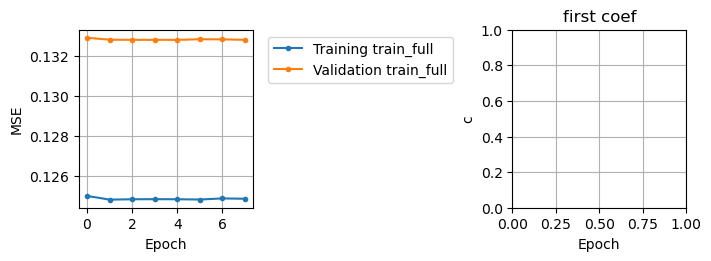

In [51]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 2.5))
exp_model = exp['LinReg']

for i, exp_name in enumerate(exp_model) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[0].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[0], ls=line_styles[i], marker='.', label='Training ' + exp_name)
    ax[0].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[1], ls=line_styles[i], marker='.', label='Validation ' + exp_name)
    #ax[1].plot(experiment.logs['coef_train'], color=list(mcolors.TABLEAU_COLORS.values())[0], ls=line_styles[i], marker='.')
ax[0].set(xlabel='Epoch', ylabel='MSE'); ax[0].grid(True)
ax[0].set(ylabel='MSE')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax[1].set(title='first coef', ylabel='c', xlabel='Epoch', yscale='linear');ax[1].grid()
plt.show()

In [37]:
exp['LinReg']['train_full']['exp'].torch_model.lin1.weight.data[0][0]

tensor(0.5506)

# Fully-connected NN for patches

## Model

The torch module class describing a model that treats the inputs/outputs by patches of pixels. 

In [52]:
class FCNN(torch.nn.Module):
    def __init__(self, nb_of_input_features, nb_of_output_features, input_patch_size, output_patch_size):
        super().__init__()
        self.input_patch_size = input_patch_size
        self.output_patch_size = output_patch_size
        
        self.lin1 = torch.nn.Linear(nb_of_input_features*input_patch_size**2, 50, bias=True)
        self.lin2 = torch.nn.Linear(50, 50, bias=True)
        self.lin3 = torch.nn.Linear(50, nb_of_output_features*output_patch_size**2, bias=True)
        
        self.cut_border_pix_output = self.input_patch_size//2 - self.output_patch_size//2
        self.cut_border_pix_input = None

    def forward(self, x):
        batch_len = x.shape[0]
        output_h = x.shape[2]-2*(self.cut_border_pix_output)
        output_w = x.shape[3]-2*(self.cut_border_pix_output)
        
        # create patches of size 'input_patch_size' and join them into batches (zero padding - will remove border pixels)
        res = torch.nn.functional.unfold(x, kernel_size=self.input_patch_size, dilation=1, padding=0, stride=1)
        res = torch.permute(res, dims=(0,2,1))
        res = torch.flatten(res, end_dim=1)
        
        # pass though the FCNN
        res = self.lin1(res)
        res = torch.nn.functional.relu(res)
        res = self.lin2(res)
        res = torch.nn.functional.relu(res)
        res = self.lin3(res)
        
        # reshape the output patches back into a 4D torch tensor
        res = torch.permute(res.unflatten(dim=0, sizes=[batch_len,-1]),dims=(0,2,1))
        res = torch.nn.functional.fold(res, output_size=(output_h,output_w), kernel_size=self.output_patch_size, dilation=1, padding=0, stride=1)
        # compute the divider needed to get correct values in case of overlapping patches (will give mean over all overlapping patches)
        mask_ones = torch.ones((1,1,output_h,output_w)).to(x.device)
        divisor = torch.nn.functional.fold(torch.nn.functional.unfold(mask_ones, kernel_size=self.output_patch_size), \
                                           kernel_size=self.output_patch_size, output_size=(output_h,output_w))   
        res = res/divisor.view(1,1,output_h,output_w)
        
        return res

## Experiments

In [53]:
model_name = 'FCNN'

In [54]:
list_of_exps = ['patch_3-1', 'patch_5-3']

In [55]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [56]:
input_features_FCNN = ['normalized_sosstsst']
output_features_FCNN = ['normalized_sosstsst_var']

In [57]:
exp['FCNN']['patch_3-1']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=FCNN(nb_of_input_features=len(input_features_FCNN), nb_of_output_features=len(output_features_FCNN), \
                                       input_patch_size=3, output_patch_size=1), \
                      label='FCNN_patched', \
                      version_name='var_patch_3-1', \
                      input_features=input_features_FCNN, \
                      target_features=output_features_FCNN, \
                      datamodule=datamodule,\
                      max_epochs=50, \
                      limit_train_batches=1.0,
                      loss = torch.nn.MSELoss(),\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-4) 

In [58]:
exp['FCNN']['patch_5-3']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=FCNN(nb_of_input_features=len(input_features_FCNN), nb_of_output_features=len(output_features_FCNN), \
                                       input_patch_size=5, output_patch_size=3), \
                      label='FCNN_patched', \
                      version_name='var_patch_5-3', \
                      input_features=input_features_FCNN, \
                      target_features=output_features_FCNN, \
                      datamodule=datamodule,\
                      max_epochs=50, \
                      limit_train_batches=1.0,\
                      loss = torch.nn.MSELoss(),\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-4)

## Training

In [43]:
exp['FCNN']['patch_3-1']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type    | Params
----------------------------------------
0 | torch_model | FCNN    | 3.1 K 
1 | loss        | MSELoss | 0     
----------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//FCNN_patched/var_patch_3-1/events.out.tfevents.1669661966.jupyter-anastasiagor.6147.1


In [44]:
exp['FCNN']['patch_5-3']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type    | Params
----------------------------------------
0 | torch_model | FCNN    | 4.3 K 
1 | loss        | MSELoss | 0     
----------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//FCNN_patched/var_patch_5-3/events.out.tfevents.1669662444.jupyter-anastasiagor.6147.2


logs//FCNN_patched/var_patch_3-1/events.out.tfevents.1669661966.jupyter-anastasiagor.6147.1
logs//FCNN_patched/var_patch_5-3/events.out.tfevents.1669662444.jupyter-anastasiagor.6147.2


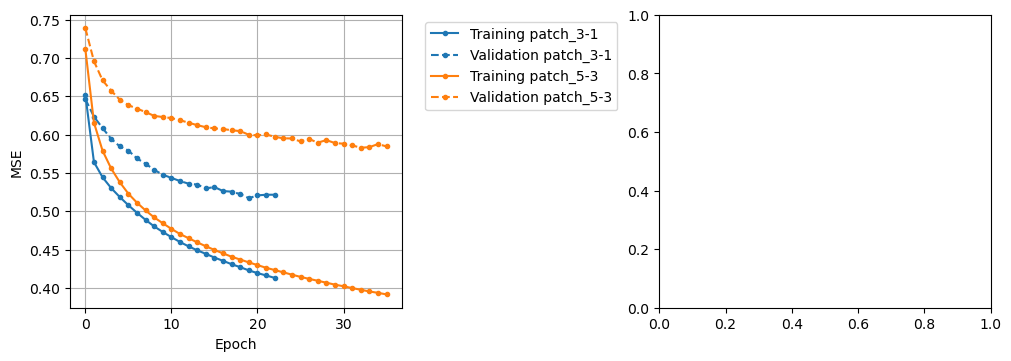

In [45]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
exp_model = exp['FCNN']

for i, exp_name in enumerate(['patch_3-1', 'patch_5-3']) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[0].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[i], \
               ls=line_styles[0], marker='.', label='Training ' + exp_name)
    ax[0].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[i], \
               ls=line_styles[1], marker='.', label='Validation ' + exp_name)
ax[0].set(xlabel='Epoch', ylabel='MSE'); ax[0].grid(True)
ax[0].set(ylabel='MSE')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Convolutional NN model

## Model

In [59]:
class CNN(torch.nn.Module):
    def __init__(self, nb_of_input_features, nb_of_output_features, padding='same', padding_mode='replicate', kernel_size=3):
        super().__init__()
        self.padding = padding
        self.kernel_size = kernel_size
        self.padding_mode = 'replicate'
        
        self.cut_border_pix_input = None
        if self.padding == 'same' :
            self.cut_border_pix_output = self.cut_border_pix_input
        if self.padding == 'valid' :
            self.cut_border_pix_output = (self.cut_border_pix_input or 0) + self.kernel_size//2
        
        self.conv1 = torch.nn.Conv2d(in_channels=nb_of_input_features, out_channels=64, kernel_size=self.kernel_size, \
                                     padding=self.padding,  padding_mode=self.padding_mode) 
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=self.kernel_size, padding='same', padding_mode=self.padding_mode) 
        self.conv3 = torch.nn.Conv2d(64, nb_of_output_features, kernel_size=self.kernel_size, padding='same', padding_mode=self.padding_mode)

    def forward(self, x):
        res = self.conv1(x)
        res = torch.nn.functional.relu(res)
        res = self.conv2(res)
        res = torch.nn.functional.relu(res)
        res = self.conv3(res)
        return res        

## Experiments

In [60]:
model_name = 'CNN'

In [61]:
list_of_exps = ['kernel3', 'kernel5']

In [62]:
for exp_name in list_of_exps :
    exp[model_name][exp_name] = dict()

In [63]:
input_features_CNN = input_features_FCNN
output_features_CNN = output_features_FCNN

In [64]:
exp['CNN']['kernel3']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=CNN(len(input_features_LinReg),len(output_features_CNN), padding='valid', kernel_size=3),\
                      label='CNN', \
                      version_name='kernel3', \
                      input_features=input_features_CNN, \
                      target_features=output_features_CNN, 
                      datamodule=datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0,\
                      loss = torch.nn.MSELoss(),\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-4) 

In [65]:
exp['CNN']['kernel5']['exp'] = Experiment(pl_class=GenericPyLiModule, \
                      torch_model=CNN(len(input_features_LinReg),len(output_features_CNN), padding='valid', kernel_size=5),\
                      label='CNN', \
                      version_name='kernel5', \
                      input_features=input_features_CNN, \
                      target_features=output_features_CNN, 
                      datamodule=datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0,\
                      loss = torch.nn.MSELoss(),\
                      optimizer = torch.optim.Adam,\
                      learning_rate=1e-4) 

## Training

In [53]:
exp['CNN']['kernel3']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type    | Params
----------------------------------------
0 | torch_model | CNN     | 38.1 K
1 | loss        | MSELoss | 0     
----------------------------------------
38.1 K    Trainable params
0         Non-trainable params
38.1 K    Total params
0.153     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//CNN/kernel3/events.out.tfevents.1669663184.jupyter-anastasiagor.6147.3


In [54]:
exp['CNN']['kernel5']['exp'].run()
clear_output(wait=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type    | Params
----------------------------------------
0 | torch_model | CNN     | 105 K 
1 | loss        | MSELoss | 0     
----------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.423     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

logs//CNN/kernel5/events.out.tfevents.1669663445.jupyter-anastasiagor.6147.4


logs//CNN/kernel3/events.out.tfevents.1669663184.jupyter-anastasiagor.6147.3
logs//CNN/kernel5/events.out.tfevents.1669663445.jupyter-anastasiagor.6147.4


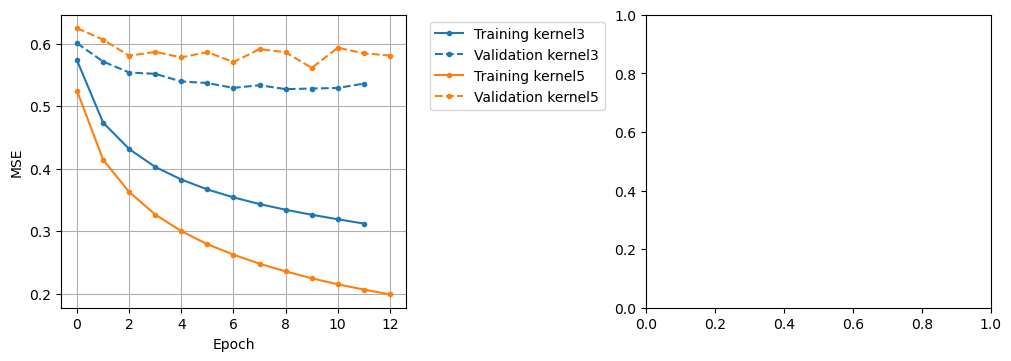

In [55]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
exp_model = exp['CNN']

for i, exp_name in enumerate(['kernel3', 'kernel5']) :
    experiment = exp_model[exp_name]['exp']
    experiment.get_logs()
    ax[0].plot(experiment.logs['loss_train'], color=list(mcolors.TABLEAU_COLORS.values())[i], \
               ls=line_styles[0], marker='.', label='Training ' + exp_name)
    ax[0].plot(experiment.logs['loss_val'], color=list(mcolors.TABLEAU_COLORS.values())[i], \
               ls=line_styles[1], marker='.', label='Validation ' + exp_name)
ax[0].set(xlabel='Epoch', ylabel='MSE'); ax[0].grid(True)
ax[0].set(ylabel='MSE')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Compare results

In [66]:
%%time
test_datamodule = datamodule

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [67]:
list_of_models = ['LinReg', 'CNN', 'FCNN']

In [69]:
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['exp'].pylight_model
        exp_dict['best_model'] = model.load_from_checkpoint(torch_model=model.torch_model, loss=model.loss,\
                                                            checkpoint_path=exp_dict['exp'].get_checkpoint_path(), \
                                                            **exp_dict['exp'].kwargs)
        trainer = pl.Trainer(accelerator='gpu', devices=1)
        print(model_name + ' ' + exp_name)
        test_dict = trainer.test(exp_dict['best_model'], datamodule=test_datamodule)
        exp_dict['loss_vs_dataset'] = dict()
        exp_dict['loss_diffs_vs_dataset'] = dict()
        exp_dict['corr_coef_vs_dataset'] = dict()
        for feature in ['sosstsst_var', 'normalized_sosstsst_var'] :
            if 'loss_test_'+feature+'/dataloader_idx_0' in test_dict[0] :
                exp_dict['loss_vs_dataset'][feature] = [test_dict[ds]['loss_test_'+feature+'/dataloader_idx_'+str(ds)] \
                                                        for ds in range(len(data_dict))]
            if 'loss_grad_test_'+feature+'/dataloader_idx_0' in test_dict[0] :
                exp_dict['loss_diffs_vs_dataset'][feature] = [test_dict[ds]['loss_grad_test_'+feature+'/dataloader_idx_'+str(ds)] \
                                                              for ds in range(len(data_dict))]
            if 'corr_coef_'+feature+'/dataloader_idx_0' in test_dict[0] :
                exp_dict['corr_coef_vs_dataset'][feature] = [test_dict[ds]['corr_coef_'+feature+'/dataloader_idx_'+str(ds)] \
                                                          for ds in range(len(data_dict))]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LinReg train_full


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  corr_coef_normalized_sosstsst_var             0.7424668073654175                    0.7201360464096069
        corr_coef_sosstsst_var                  0.7424668595055409                    0.7201358497565779
loss_grad_test_normalized_sosstsst_var          12.267231941223145                    3.6980648040771484
     loss_grad_test_sosstsst_var                0.890879861871047                   0.00037107466017656076
  loss_test_normalized_sosstsst_var            0.47888341546058655                    0.5025376677513123
        loss_test_sosstsst_var                  0.1290524140135712                   0.005033988350724192
───────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CNN kernel3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  corr_coef_normalized_sosstsst_var             0.827827513217926                     0.7424652576446533
        corr_coef_sosstsst_var                  0.8278278550746857                    0.742465241617972
loss_grad_test_normalized_sosstsst_var          9.996384620666504                     2.729644536972046
     loss_grad_test_sosstsst_var                0.725964605309799                   0.00027390052375168936
  loss_test_normalized_sosstsst_var            0.34693291783332825                   0.44384491443634033
        loss_test_sosstsst_var                 0.09349354509050518                   0.004446053439645621
─────────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CNN kernel5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  corr_coef_normalized_sosstsst_var             0.8248639106750488                    0.6862339377403259
        corr_coef_sosstsst_var                  0.8248638175132276                    0.6862338063227691
loss_grad_test_normalized_sosstsst_var          11.677567481994629                    3.1483819484710693
     loss_grad_test_sosstsst_var                0.8480566666211324                  0.00031591796996620716
  loss_test_normalized_sosstsst_var             0.3950560390949249                    0.5389610528945923
        loss_test_sosstsst_var                 0.10646212921082257                   0.005398841421008279
───────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FCNN patch_3-1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  corr_coef_normalized_sosstsst_var             0.8283371925354004                    0.7426571846008301
        corr_coef_sosstsst_var                  0.8283368083169949                    0.7426572425115002
loss_grad_test_normalized_sosstsst_var           9.42674732208252                     2.802495241165161
     loss_grad_test_sosstsst_var                0.6845959681471344                  0.00028121046362701953
  loss_test_normalized_sosstsst_var             0.3296300172805786                   0.47249311208724976
        loss_test_sosstsst_var                 0.08883072547624545                   0.004733023075577518
────────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


FCNN patch_5-3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Test metric                           DataLoader 0                          DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  corr_coef_normalized_sosstsst_var             0.7907460927963257                    0.6914848685264587
        corr_coef_sosstsst_var                  0.7907465325397744                    0.6914848781974199
loss_grad_test_normalized_sosstsst_var          11.203274726867676                     3.28585147857666
     loss_grad_test_sosstsst_var                0.8136121165974872                  0.00032971198844274026
  loss_test_normalized_sosstsst_var             0.3968082368373871                    0.517210066318512
        loss_test_sosstsst_var                 0.10693427608666532                   0.005180963496186264
─────────────────────────

## Image example

In [70]:
test_dl = test_datamodule.test_dataloader()[1]

In [71]:
test_di = iter(test_dl)

In [72]:
sample = next(test_di)

In [73]:
idx = 0 #index inside the batch

In [74]:
snapshot_true_error = np.squeeze(sample['sosstsst_var'][idx])

In [75]:
for i, model_name in enumerate(list_of_models) :
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        model = exp_dict['best_model']
        exp_dict['snapshot'] = np.squeeze((model.predict_step(sample, idx, 0)['sosstsst_var'][idx]).detach().numpy())

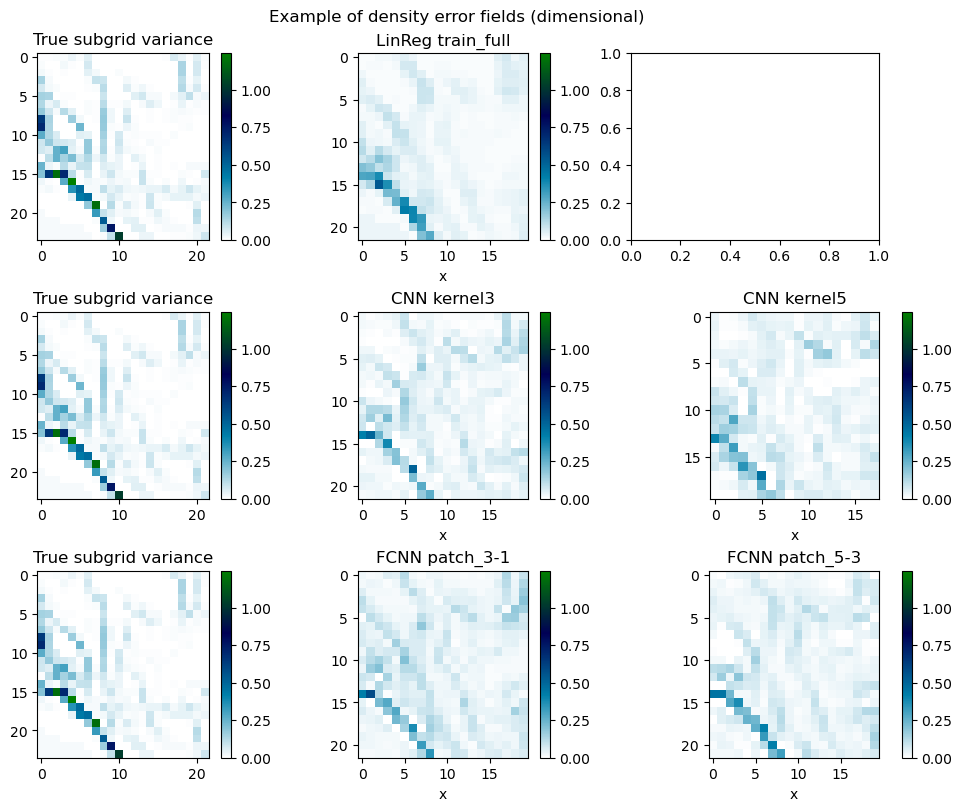

In [76]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,8), constrained_layout=True)
fig.suptitle('Example of density error fields (dimensional)')

for i, model_name in enumerate(list_of_models) :
    img = ax[i,0].imshow(snapshot_true_error, cmap='ocean_r')
    fig.colorbar(img, ax=ax[i,0])
    ax[i,0].set(title='True subgrid variance')
    color_min = img.colorbar.vmin
    color_max = img.colorbar.vmax
    for j, exp_name in enumerate(list(exp[model_name].keys())) :
        exp_dict = exp[model_name][exp_name]
        img = ax[i,j+1].imshow(exp_dict['snapshot'], cmap='ocean_r', vmin=color_min, vmax=color_max)
        fig.colorbar(img, ax=ax[i,j+1])
        ax[i,j+1].set(title=model_name+' '+exp_name, xlabel='x')
plt.show()

## Compare MSE across datasets

### MSE of subgrid variance

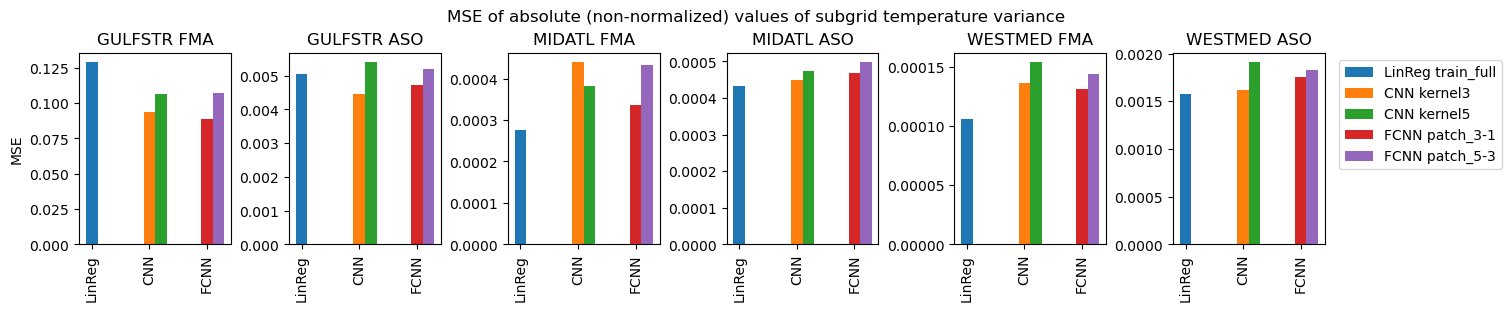

In [79]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('MSE of absolute (non-normalized) values of subgrid temperature variance')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'sosstsst_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_vs_dataset'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['loss_vs_dataset'][feature][region], width=bar_width, color=list(mcolors.TABLEAU_COLORS.values())[bar_counter],\
                              label=model_name+' '+exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### MSE of horizontal gradient of the subgrid variance

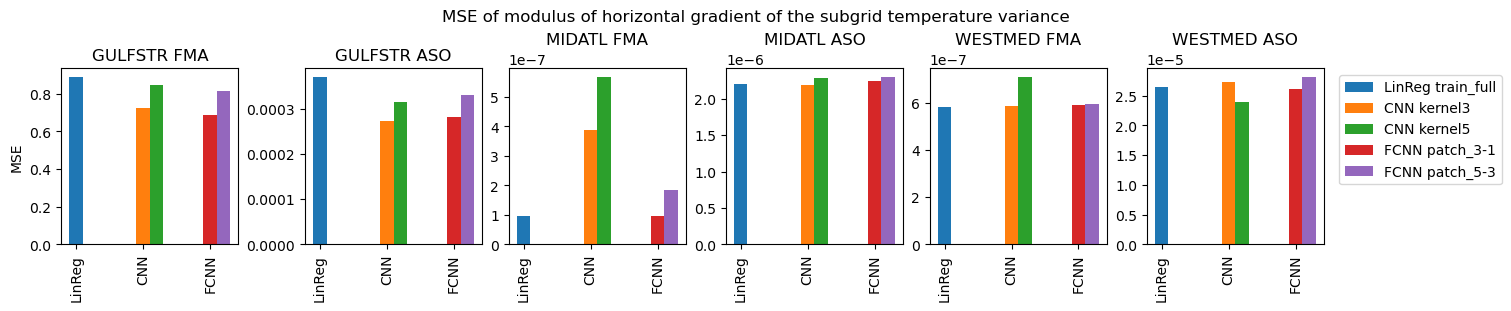

In [82]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('MSE of modulus of horizontal gradient of the subgrid temperature variance')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'sosstsst_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_diffs_vs_dataset'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['loss_diffs_vs_dataset'][feature][region], width=bar_width, color=list(mcolors.TABLEAU_COLORS.values())[bar_counter],\
                              label=model_name+' '+exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Correlation coefficient

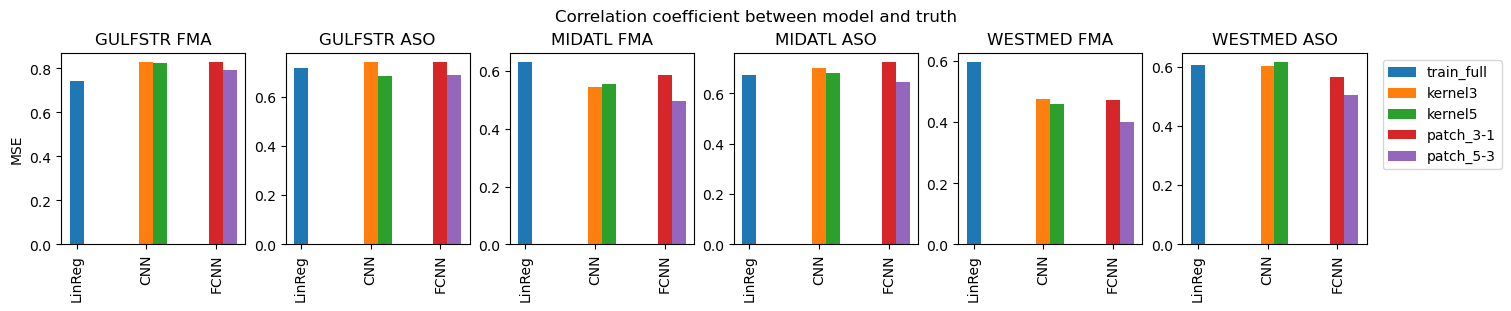

In [80]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0))
fig.suptitle('Correlation coefficient between model and truth')
x = np.arange(len(list_of_models))
xlabels=list_of_models
bar_width = 0.2
feature = 'sosstsst_var'

for region in range(len(data_dict)) :
    bar_counter = 0
    for i, model_name in enumerate(list_of_models) :
        for j, exp_name in enumerate(list(exp[model_name].keys())) :
            exp_dict = exp[model_name][exp_name]
            if (feature in exp_dict['loss_vs_dataset'].keys()) :
                ax[region].bar(x[i]+j*bar_width, exp_dict['corr_coef_vs_dataset'][feature][region], width=bar_width, color=list(mcolors.TABLEAU_COLORS.values())[bar_counter],\
                              label=exp_name)
                bar_counter+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()